# Welcome to the PERCEPT demo!

Here you will find a very simple run-through of the application of PERCEPT to a simulated dataset. In this case, we will (1) generate two random datasets with different levels of variability, (2) define a function that will perform the PERCEPT scaling on these datasets, and (3) visualise the effect of this scaling. 

⚠ If you are not familiar with the python programming language, or would prefer to see this process in action in a spreadsheet, check out the ```'simulated-template.xlsx'``` document. 

Okay - let's start by importing some libraries and functions that we will need to perform or visualise PERCEPT:

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
from loguru import logger
import seaborn as sns
import matplotlib.patches as mpatches

logger.info('Import OK')

2024-02-20 23:12:14.632 | INFO     | __main__:<cell line: 9>:9 - Import OK


For reproducibility, we will also set the 'seed'. This ensures that, while the numbers drawn will be randomly from the normal distribution, the same numbers will be collected here each time the code is run for the purposes of demonstration:

ℹ You can always change the seed value and see the result of PERCEPT on a different set of random numbers!

In [2]:
# optional: for reproducible numbers, set numpy seed
np.random.seed(567)

Ok, now it's time to generate the datasets that we will explore. Both datasets will consist of a random set of numbers, with ```data_1``` having a smaller range from which the numbers are drawn compared to ```data_2```. This means that ```data_1``` will be consistent while ```data_2``` have a large spread i.e. be noisy.

We can visualise these two datasets easily by putting them in a table:

In [3]:
# Generate two datasets with different variability
data_1 = [(val + np.random.randint(200, 400)).round(2) for val in np.random.rand(1, 5)[0]]
data_2 = [(val + np.random.randint(100, 1000)).round(2) for val in np.random.rand(1, 5)[0]]
dataset = pd.DataFrame([data_1, data_2], index=['data_1', 'data_2'])
dataset.columns = np.arange(1, 6) # Set column names to replicate number
dataset

,1,2,3,4,5
data_1,233.30,274.95,272.96,226.34,317.99
data_2,189.47,518.57,986.77,849.66,886.19


Great! Now we have some data to play with, let's dive into the nitty-gritty. First, we need to define a function that will apply the PERCEPT scaling method to a mean value based on the hypothetical mean (```m0```), the value itselt (```m1```), the penalty factor (```F```) and the p-value (```*p*```).

In [4]:
# PERCEPT as defined in Eq. 1
def percept(m0, m1, F, p):
    return m0 + ((m0 - m1) / -(F**p))

We will also define a helper function that will allow us to apply this to our datasets without having to first calculate the parameters (i.e. without having to pre-compute the mean and *p*-value). This helper function uses a one-sample t-test to assess the difference between the dataset of interest and the hypothetical mean, returning a *p*-value that is used for PERCEPT scaling. 

In [5]:
# define a simple function to apply the PERCEPT scaling
def apply_percept(data, hypothethical_mean, penalty):
    
    # 1. Calculate p-value    
    tval, pval = ttest_1samp(
        data,
        popmean=hypothethical_mean,
        nan_policy='omit'
    )

    # 2. Calculate sample mean
    sample_mean = np.mean(data)
    
    # 3. Apply percept, returning scaled mean value
    return percept(
                m0=hypothethical_mean,
                m1=sample_mean,
                F=penalty,
                p=pval
                )

Now that we have our PERCEPT function and helper function, we can apply the PERCEPT scaling method to each of our datasets. Here it is being applied to ```data_1```, using a penalty factor of 10 × *n*:

In [6]:
# Apply PERCEPT to the data
data_1_scaled_mean = apply_percept(
    data=data_1,
    hypothethical_mean=500,
    penalty=50
    )
data_1_scaled_mean

265.23906359046157

And again for ```data_2```:

In [7]:
data_2_scaled_mean = apply_percept(
    data=data_2,
    hypothethical_mean=500,
    penalty=50
    )
data_2_scaled_mean

563.7177209873093

Now let's add both the original mean value ("raw"; i.e. before scaling) and the PERCEPT value ("scaled") to the original dataset table for easy visualisation.

In [8]:
# Summarise data by adding to original dataframe
dataset['raw_mean'] = dataset.mean(axis=1).values
dataset['scaled_mean'] = [data_1_scaled_mean, data_2_scaled_mean]
dataset

,1,2,3,4,5,raw_mean,scaled_mean
data_1,233.30,274.95,272.96,226.34,317.99,265.108,265.239064
data_2,189.47,518.57,986.77,849.66,886.19,686.132,563.717721


We can see that the raw mean value for the consistent ```data_1``` has not been scaled very much at all - we would expect this from a consistent dataset that is far from the hypothetical mean of 500, and would thus produce a small (i.e. significant) *p*-value. In contrast, the scaled value for ```data_2``` has been dragged much closer to the hypothetical mean owing to the variability of the dataset, which would in turn produce a larger (i.e. less significant) *p*-value.

Finally, to really understand what is happening to each dataset nothing beats a good visual! Here, we will adjust the data format into a long-form table for easy visualisation:

In [10]:
# Prepare data for visualisation
summary = pd.melt(
    dataset.reset_index().rename(columns={'index': 'dataset'}),
    id_vars=['dataset'], # Keep the dataset labels
    value_vars=np.arange(1, 6), # Collect the raw data columns
    var_name='replicate' # Label the new column created 
    )
summary

,dataset,replicate,value
0,data_1,1,233.30
1,data_2,1,189.47
2,data_1,2,274.95
3,data_2,2,518.57
4,data_1,3,272.96
5,data_2,3,986.77
6,data_1,4,226.34
7,data_2,4,849.66
8,data_1,5,317.99
9,data_2,5,886.19


And finally generate a plot which contains the original datapoints (black circles), the hypothetical mean (purple line), the raw mean value (yellow line) and the PERCEPT scaled values (magenta dashed lines):

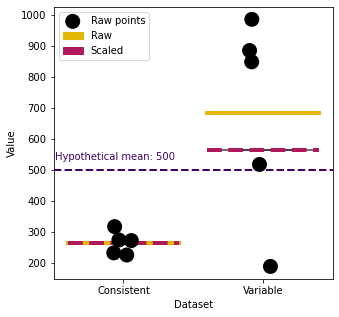

In [11]:
# Visualise the data before and after scaling
fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(
    data=summary,
    x='dataset',
    y='value',
    color='black',
    dodge=False,
    ax=ax,
    s=15,
    label='Raw points'
)
sns.boxplot(
    data=summary.groupby('dataset').mean().reset_index(),
    x='dataset',
    y='value',
    ax=ax,
    medianprops=dict(color='#E3B504', linewidth=4),
)
  
sns.boxplot(
    data=dataset.reset_index(),
    x='index',
    y='scaled_mean',
    ax=ax,
    medianprops=dict(color='#B0185E', linewidth=4, linestyle='--'),
)

# Add line at hypothetical mean
ax.axhline(500, color='#420264', linestyle='--', linewidth=2)
ax.annotate('Hypothetical mean: 500', xy=(0.005, 0.467), xycoords="axes fraction", ha='left', va='top', color='#420264')
# Set axes labels
ax.set(ylabel='Value', xlabel='Dataset', xticklabels=['Consistent', 'Variable'])

# Customise legend
handles, labels = plt.gca().get_legend_handles_labels()
raw_patch = mpatches.Patch(color='#E3B504', label='Raw mean')
scaled_patch = mpatches.Patch(color='#B0185E', label='Scaled mean')
plt.legend(handles=[handles[0], raw_patch, scaled_patch], labels=['Raw points', 'Raw', 'Scaled'], loc='upper left')

Hopefully this has helped to demonstrate how we can easily apply PERCEPT in just a few lines of code. Ready to try it out for yourself? Simply substitute your data into the datasets defined above and give it a go!